# Analytics for Data Products IDEs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nbclient.client import timestamp

In this task we use Pandas, as it is the simplest way to load, preprocess, clean, and analyse the data. The dataset is quite small (a little more than 3500 records), so there is no sense to use more advanced libraries, such as PySpark, which is dedicated to Big Data.

## Data loading and preprocessing

We load the data into Pandas DataFrame and print basic information about it. We can see that data is not clean, there is more *'opened'* events than *'closed'* events and many windows for the same user.

In [2]:
data = pd.read_csv("toolwindow_data.csv")
data.head(10)

,timestamp,event,open_type,user_id
0,1752250204033,opened,manual,1
1,1751836141616,closed,NaN,2
2,1752304475081,closed,NaN,3
3,1752498934494,opened,auto,4
4,1752141991110,closed,NaN,5
5,1752308210458,opened,auto,3
6,1752310292657,opened,auto,3
7,1752276666919,closed,NaN,6
8,1752158089077,opened,auto,5
9,1752174540366,opened,auto,7


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3503 entries, 0 to 3502
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  3503 non-null   int64 
 1   event      3503 non-null   object
 2   open_type  1865 non-null   object
 3   user_id    3503 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 109.6+ KB


In [5]:
data['event'].value_counts()

event
opened    1865
closed    1638
Name: count, dtype: int64

In [9]:
data['user_id'].value_counts()

user_id
15     188
12     162
10     160
25     137
28     126
      ... 
186      1
197      1
202      1
204      1
205      1
Name: count, Length: 205, dtype: int64

Before we start cleaning dataset we have to make one crucial assumption:

**Assumption: Each user can have only one window open at a time.**

Moreover, we sort the data by *'user_id'* and *'timestamp'* to obtain chronologically sorted events for each user. This way, we are able to match pair events (*'opened'* and *'closed'*).

In [3]:
data_sorted = data.sort_values(by = ['user_id', 'timestamp'])
data_sorted.head(10)

,timestamp,event,open_type,user_id
3481,1751826102123,opened,auto,1
1803,1751826746077,closed,NaN,1
2757,1751841258635,opened,manual,1
46,1751849544609,closed,NaN,1
1296,1751985487772,opened,manual,1
3461,1751986623885,closed,NaN,1
0,1752250204033,opened,manual,1
1027,1752250204781,closed,NaN,1
1013,1752250205587,opened,manual,1
1807,1752257432775,closed,NaN,1


We create a list ***windows***, in which we store matched events (also not correctly matched - only open or close event), and a dictionary ***current_windows***, in which we store information about currently open windows for users. Then for each row in DataFrame with sorted data we check which event is it - opened or closed, and if selected user has any window opened.

If event is equal 'opened' and user has already opened window, we close the old window without timestamp of closed event. Then and also for other cases, we add information about new window and user to ***current_windows***. When event is equal 'closed', we check if this user has opened window - if yes, then we add information about this window (with opened and closed timestamp) to ***windows*** and remove it form ***current_windows***, otherwise we add only information about this closure (no opened event matched).

At the end we add to ***windows*** rows with information about events in ***current_windows*** - these are only opened events without matched closed event. Then we transform ***windows*** into Pandas DataFrame.

In [4]:
windows = []
current_windows = {}

for row in data_sorted.itertuples():
    user = row.user_id
    event = row.event
    if event == 'opened':
        if user in current_windows: # if there is old window opened for user then close it
            windows.append([user, current_windows[user]['open_type'], current_windows[user]['timestamp'], None])

        # open new window
        current_windows[user] = {'open_type': row.open_type, 'timestamp': row.timestamp}

    else: # closed
        if user in current_windows: # correct open and close
            windows.append([user, current_windows[user]['open_type'], current_windows[user]['timestamp'], row.timestamp])
            current_windows.pop(user)

        else: # user do not have opened window
            windows.append([user, None, None, row.timestamp])

for user in list(current_windows.keys()): # not closed windows
    windows.append([user, current_windows[user]['open_type'], current_windows[user]['timestamp'], None])

windows = pd.DataFrame(windows, columns = ['user_id', 'open_type', 'open_timestamp', 'close_timestamp'])
windows.head(10)

,user_id,open_type,open_timestamp,close_timestamp
0,1,auto,1.751826e+12,1.751827e+12
1,1,manual,1.751841e+12,1.751850e+12
2,1,manual,1.751985e+12,1.751987e+12
3,1,manual,1.752250e+12,1.752250e+12
4,1,manual,1.752250e+12,1.752257e+12
5,1,manual,1.752843e+12,1.752843e+12
6,1,manual,1.752843e+12,1.752845e+12
7,1,manual,1.752877e+12,1.752885e+12
8,1,manual,1.753104e+12,1.753107e+12
9,2,auto,1.751656e+12,1.751656e+12


In [5]:
windows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          1881 non-null   int64  
 1   open_type        1865 non-null   object 
 2   open_timestamp   1865 non-null   float64
 3   close_timestamp  1638 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 58.9+ KB


This DataFrame still includes orphaned events. Before we start analysing, we remove these events.

In [7]:
clean_data = windows.dropna()
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1622 entries, 0 to 1846
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          1622 non-null   int64  
 1   open_type        1622 non-null   object 
 2   open_timestamp   1622 non-null   float64
 3   close_timestamp  1622 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 63.4+ KB


Now we have 1622 pairs of events.

In next step we transform timestamps in [ms] to datatime format, so we obtain dates and times.

In [9]:
clean_data['open_timestamp'] = pd.to_datetime(clean_data['open_timestamp'], unit='ms', errors='coerce')
clean_data['close_timestamp'] = pd.to_datetime(clean_data['close_timestamp'], unit='ms', errors='coerce')

clean_data.head(10)

C:\Users\magda\AppData\Local\Temp\ipykernel_29128\480690752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['open_timestamp'] = pd.to_datetime(clean_data['open_timestamp'], unit='ms', errors='coerce')
C:\Users\magda\AppData\Local\Temp\ipykernel_29128\480690752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['close_timestamp'] = pd.to_datetime(clean_data['close_timestamp'], unit='ms', errors='coerce')


,user_id,open_type,open_timestamp,close_timestamp
0,1,auto,2025-07-06 18:21:42.123,2025-07-06 18:32:26.077
1,1,manual,2025-07-06 22:34:18.635,2025-07-07 00:52:24.609
2,1,manual,2025-07-08 14:38:07.772,2025-07-08 14:57:03.885
3,1,manual,2025-07-11 16:10:04.033,2025-07-11 16:10:04.781
4,1,manual,2025-07-11 16:10:05.587,2025-07-11 18:10:32.775
5,1,manual,2025-07-18 12:56:48.702,2025-07-18 12:57:01.856
6,1,manual,2025-07-18 12:57:04.801,2025-07-18 13:24:33.719
7,1,manual,2025-07-18 22:17:24.540,2025-07-19 00:22:21.824
8,1,manual,2025-07-21 13:27:20.917,2025-07-21 14:07:24.951
9,2,auto,2025-07-04 19:09:01.008,2025-07-04 19:09:59.632


Then we calculate how long each window was opened (in seconds), and we save result in new column *opened_time[s]*.

In [10]:
clean_data['opened_time[s]'] = (clean_data['close_timestamp'] - clean_data['open_timestamp']).dt.total_seconds()
clean_data.head(10)

C:\Users\magda\AppData\Local\Temp\ipykernel_29128\559595878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['opened_time[s]'] = (clean_data['close_timestamp'] - clean_data['open_timestamp']).dt.total_seconds()


,user_id,open_type,open_timestamp,close_timestamp,opened_time[s]
0,1,auto,2025-07-06 18:21:42.123,2025-07-06 18:32:26.077,643.954
1,1,manual,2025-07-06 22:34:18.635,2025-07-07 00:52:24.609,8285.974
2,1,manual,2025-07-08 14:38:07.772,2025-07-08 14:57:03.885,1136.113
3,1,manual,2025-07-11 16:10:04.033,2025-07-11 16:10:04.781,0.748
4,1,manual,2025-07-11 16:10:05.587,2025-07-11 18:10:32.775,7227.188
5,1,manual,2025-07-18 12:56:48.702,2025-07-18 12:57:01.856,13.154
6,1,manual,2025-07-18 12:57:04.801,2025-07-18 13:24:33.719,1648.918
7,1,manual,2025-07-18 22:17:24.540,2025-07-19 00:22:21.824,7497.284
8,1,manual,2025-07-21 13:27:20.917,2025-07-21 14:07:24.951,2404.034
9,2,auto,2025-07-04 19:09:01.008,2025-07-04 19:09:59.632,58.624


The DataFrame is ready to analysis.

## Analysis

To begin, we check values counts for column *open_type*.
- 1000 windows was opened automatically.
- 622 windows was opened manually.

In [12]:
clean_data['open_type'].value_counts()

open_type
auto      1000
manual     622
Name: count, dtype: int64

At the beginning, we calculate basic statistics, such as mean, std, min, median (50%), and max for each *open_type*. We also plot a boxplot to visualize the distribution of window-open durations for the two opening types.

In [13]:
summary = clean_data.groupby('open_type')['opened_time[s]'].describe()
summary

,count,mean,std,min,25%,50%,75%,max
open_type,,,,,,,,
auto,1000.0,6323.446365,28626.912755,0.154,35.19550,184.8205,1195.73675,409873.748
manual,622.0,1470.259863,10725.427369,0.015,2.15125,12.0590,135.66375,180918.694


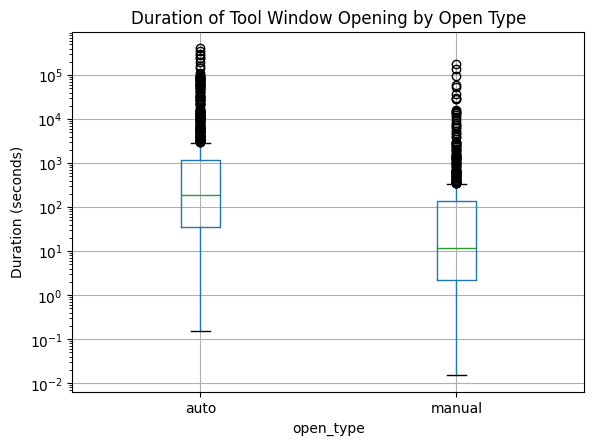

In [19]:
clean_data.boxplot(column='opened_time[s]', by='open_type')
plt.title("Duration of Tool Window Opening by Open Type")
plt.suptitle("")
plt.ylabel("Duration (seconds)")
plt.yscale('log')
plt.show()

Boxplot description:
- Green lines inside the box present median (50th percentile) - central value.
- Box spans from the 1st quartile (25%) to the 3rd quartile (75%). It represents the middle 50% of the data.
- Horizontal lines above and below the box (whiskers) show the range of “typical” values.
- Points outside the whiskers are outliers - unusually high or low values compared to most observations.

The plot shows that there are many outliers. To reduce the influence of these extreme values, we remove outliers by keeping only records where the duration is below the 99th percentile.

In [32]:
quantile99 = clean_data['opened_time[s]'].quantile(0.99)
filtered_data = clean_data[clean_data['opened_time[s]'] < quantile99]
len(filtered_data)

1605

In [33]:
summary2 = filtered_data.groupby('open_type')['opened_time[s]'].describe()
summary2

,count,mean,std,min,25%,50%,75%,max
open_type,,,,,,,,
auto,986.0,3569.577666,12098.341998,0.154,33.44325,173.786,1085.5995,88750.663
manual,619.0,808.187289,4331.017841,0.015,2.14150,11.921,134.3735,58224.159


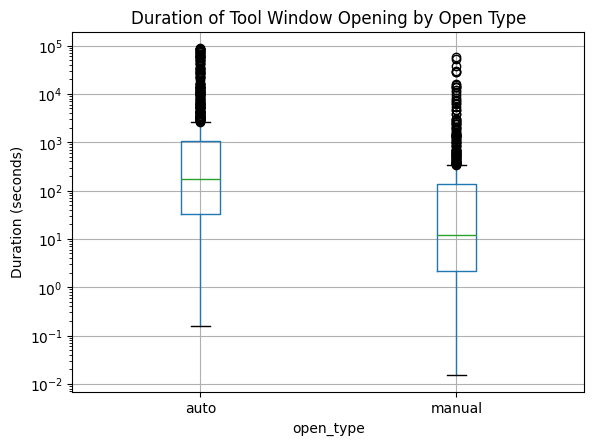

In [34]:
filtered_data.boxplot(column='opened_time[s]', by='open_type')
plt.title("Duration of Tool Window Opening by Open Type")
plt.suptitle("")
plt.ylabel("Duration (seconds)")
plt.yscale('log')
plt.show()

After this filtering, the maximum values for both open_type categories decreased significantly. However, the median values remained almost unchanged, and a noticeable number of outliers are still present.

To calculate statistically significant we use **Mann–Whitney U Test**.

The Mann–Whitney U test is a non-parametric statistical test.
We use it to compare two independent groups, but the data does not follow a normal distribution — which is our case:
- The duration values have many extreme outliers.
- The distribution is highly skewed.
- The groups (manual and auto) have different variances.

Instead of comparing means directly, it ranks all values from both groups together and checks whether one group tends to have larger ranks than the other. It tests whether one type (manual or auto) tends to have longer open durations than the other.

In [35]:
from scipy.stats import mannwhitneyu

manual = filtered_data[filtered_data['open_type'] == 'manual']['opened_time[s]']
auto = filtered_data[filtered_data['open_type'] == 'auto']['opened_time[s]']

stat, p = mannwhitneyu(manual, auto, alternative='two-sided')
print(f"U-statistic: {stat}, p-value: {p}")

U-statistic: 153827.5, p-value: 6.15991585334434e-63


The p-value is close to 0, what means that the difference is statistically significant, so it is not random chance.

## Interpretation

Above results show that clear differences in durations of window openings between automatic and manual openings.

Automatic openings have a very high average duration and maximum duration. It means that some automatically opened windows remained open for a very long time. The median duration is relatively low, what suggests that most openings are short and only a few extremely long openings increase average duration.

Manual openings have a lower mean, median, and maximum duration. This means that users who open window manually usually close it sooner. Long duration sessions are less common in this case.

In both cases (auto and manual) the distributions are highly skewed and have many outliers.

The Mann–Whitney U test showed that the difference in durations between manual and automatic openings is statistically significant.